At first some python libraries are imported:

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from matplotlib.ticker import FuncFormatter
from shapely.geometry import Polygon, Point

The model data is imported as a dataset:

In [3]:
temp = xr.open_dataset("/students_files/data/slo0043_echam6_code167_mm_1001_8850.ncslo0043_echam6_code167_mm_1001_8850.nc")
press = xr.open_dataset("/students_files/data/slo0043_echam6_code151_mm_1001-8850.ncslo0043_echam6_code151_mm_1001-8850.nc")
large_scale_prec = xr.open_dataset("/students_files/data/slo0043_echam6_code142_mm_1001_8850.ncslo0043_echam6_code142_mm_1001_8850.nc")
convective_prec = xr.open_dataset("/students_files/data/slo0043_echam6_code143_mm_1001_8850.ncslo0043_echam6_code143_mm_1001_8850.nc")
sum_var = large_scale_prec['var142'] + convective_prec['var143']
prec = xr.Dataset({'var260': sum_var})
prec = prec.assign_coords(coords=large_scale_prec.coords)

The longitude and latitude coordinates are adjusted.

In [4]:
# adjust values of lon and lat and show dataset

def adjust_lon_lat(ds, lon_name, lat_name, reverse = False):
    """Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude."""
    if reverse == True:
        ds = ds.reindex({lat_name:ds[lat_name][::-1]})
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])
    ds = (ds
          .swap_dims({lon_name: '_longitude_adjusted'})
          .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
          .drop(lon_name))
    ds = ds.rename({'_longitude_adjusted': lon_name})
    return ds

temp = adjust_lon_lat(temp, lon_name="lon", lat_name="lat", reverse=True)
prec = adjust_lon_lat(prec, lon_name="lon", lat_name="lat", reverse=True)
press = adjust_lon_lat(press, lon_name="lon", lat_name="lat", reverse=True)

Creating a Baltic Sea drainage basin boolean mask:

In [6]:
corner_points = [
    (18.0, 49),
    (23.0, 49),
    (28.0, 55.0),
    (32.0, 56.0),
    (35.0, 62.0),
    (30.0, 62.0),
    (29.0, 67.0),
    (19.0, 68.0),
    (12.0, 61.0),
    (12.0, 57.5),
    (8.0, 56.5),
    (10.0, 53.0),
    (13.5, 52.5)
]

polygon = Polygon(corner_points)

lat_mask = (temp['lat'] >= polygon.bounds[1]) & (temp['lat'] <= polygon.bounds[3])
lon_mask = (temp['lon'] >= polygon.bounds[0]) & (temp['lon'] <= polygon.bounds[2])
mask = (lat_mask & lon_mask)

lat_values = temp['lat'].values
lon_values = temp['lon'].values
for i in range(len(lat_values)):
    for j in range(len(lon_values)):
        if not polygon.contains(Point(lon_values[j], lat_values[i])):
            mask[i, j] = False

The baltic region outline for map plots is prepared:

In [7]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def subplot_cartopy_nice_baltic(ax):    
    """
    Adjust cartopy plots for the Baltic Sea
    """
    ax.set_aspect("auto")
    ax.coastlines("10m")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.0, linestyle='-')
    gl.top_labels  = False
    gl.left_labels  = True
    gl.right_labels  = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator(list(np.arange(-90, 60, 10)))
    gl.ylocator = mticker.FixedLocator(list(np.arange(-60, 80, 5)))

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.spines['geo'].set_linewidth(1)
    ax.spines['geo'].set_edgecolor('black')
    ax.set_aspect('auto')

# Seasonal correlation between NAO and temperature/precipitation

At first we will display the seasonal NAO:

In [8]:
press_range_il = press.sel(lat=slice(55,68), lon=slice(-37,-24))
press_range_ah = press.sel(lat=slice(27,40), lon=slice(-39,-26))
press_il = np.zeros(94200)
press_ah = np.zeros(94200)

In [9]:
for i in range (0, 94200):
    press_il[i] = press_range_il['var151'].isel(time=i).min(dim=['lat','lon'])
    press_ah[i] = press_range_ah['var151'].isel(time=i).max(dim=['lat','lon'])

<xarray.DataArray 'var151' ()>
array(2059.38348992)
<xarray.DataArray 'var151' ()>
array(1792.79490446)
<xarray.DataArray 'var151' ()>
array(2180.99406847)
<xarray.DataArray 'var151' ()>
array(3168.5341604)


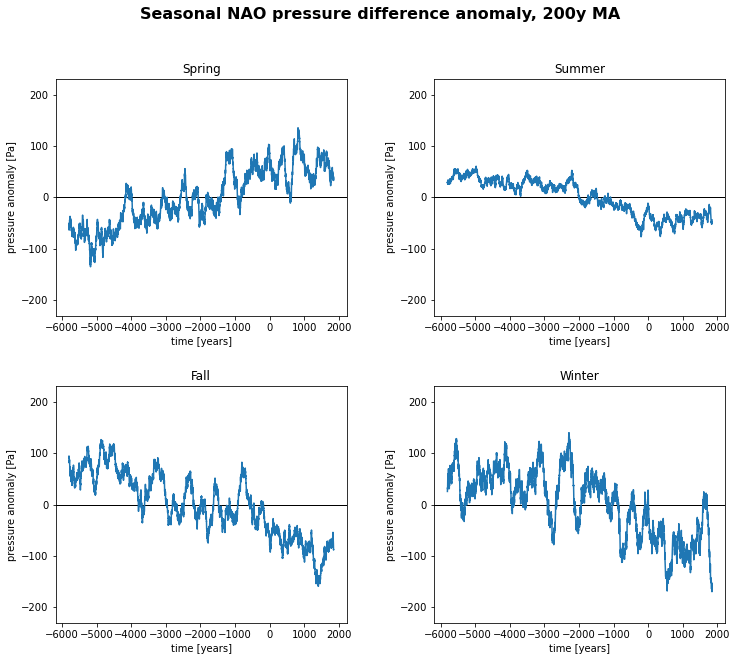

In [11]:
delta_press_monthly = press_ah - press_il
time = np.arange(0,94200)
delta_press_monthly = xr.DataArray(delta_press_monthly, dims=['time'], coords={'time': time})
rolling_data = delta_press_monthly.isel(time=slice(2, None))
rolling_data = rolling_data.rolling(time=3, center=False, min_periods=3).mean()
rolling_data = rolling_data[2::3]
seasonal_delta_press = xr.Dataset({"var151": ("time", rolling_data)}, coords={"time": rolling_data.coords["time"]})


# Creating spring_delta_press DataArray and applying 200y MA
spring_delta_press = seasonal_delta_press['var151'][0::4]
spring_mean = spring_delta_press.mean()
delta_press_mean = spring_delta_press.mean(dim=['time'])
delta_press_mean = float(delta_press_mean.values)
spring_delta_press -= delta_press_mean
spring_delta_press.coords['time'] = range(-6000, -6000+len(spring_delta_press))
spring_delta_press_plot = spring_delta_press.rolling(time=200).mean()

# Creating summer_delta_press DataArray and applying 200y MA
summer_delta_press = seasonal_delta_press['var151'][1::4]
summer_mean = summer_delta_press.mean()
delta_press_mean = summer_delta_press.mean(dim=['time'])
delta_press_mean = float(delta_press_mean.values)
summer_delta_press -= delta_press_mean
summer_delta_press.coords['time'] = range(-6000, -6000+len(summer_delta_press))
summer_delta_press_plot = summer_delta_press.rolling(time=200).mean()

# Creating fall_delta_press DataArray and applying 200y MA
fall_delta_press = seasonal_delta_press['var151'][2::4]
fall_mean = fall_delta_press.mean()
delta_press_mean = fall_delta_press.mean(dim=['time'])
delta_press_mean = float(delta_press_mean.values)
fall_delta_press -= delta_press_mean
fall_delta_press.coords['time'] = range(-6000, -6000+len(fall_delta_press))
fall_delta_press_plot = fall_delta_press.rolling(time=200).mean()

# Creating winter_delta_press DataArray and applying 200y MA
winter_delta_press = seasonal_delta_press['var151'][3::4]
winter_mean = winter_delta_press.mean()
delta_press_mean = winter_delta_press.mean(dim=['time'])
delta_press_mean = float(delta_press_mean.values)
winter_delta_press -= delta_press_mean
winter_delta_press.coords['time'] = range(-6000, -6000+len(winter_delta_press))
winter_delta_press_plot = winter_delta_press.rolling(time=200).mean()


# Creating the four plots
fig, axs = plt.subplots(2, 2, figsize=(12,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})

im1 = axs[0,0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[0,0].plot(spring_delta_press_plot['time'], spring_delta_press_plot)
axs[0,0].set_title('Spring')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('pressure anomaly [Pa]')
axs[0,0].set_ylim([-230,230])

im2 = axs[0,1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[0,1].plot(summer_delta_press_plot['time'], summer_delta_press_plot)
axs[0,1].set_title('Summer')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('pressure anomaly [Pa]')
axs[0,1].set_ylim([-230,230])

im3 = axs[1,0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[1,0].plot(fall_delta_press_plot['time'], fall_delta_press_plot)
axs[1,0].set_title('Fall')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('pressure anomaly [Pa]')
axs[1,0].set_ylim([-230,230])

im4 = axs[1,1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[1,1].plot(winter_delta_press_plot['time'], winter_delta_press_plot)
axs[1,1].set_title('Winter')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('pressure anomaly [Pa]')
axs[1,1].set_ylim([-230,230]);

fig.suptitle('Seasonal NAO pressure difference anomaly, 200y MA', fontsize=16, fontweight='bold');

print(spring_mean)
print(summer_mean)
print(fall_mean)
print(winter_mean)

In [21]:
print("NAO pressure difference anomalies during climate periods:")
print("\n SPRING")
print("HCO", spring_delta_press.isel(time=slice(6000 - 2664, 6000 - 1567)).mean(dim=['time']))
print("MCA", spring_delta_press.isel(time=slice(6000 + 604 , 6000 + 843 )).mean(dim=['time']))
print("LIA1", spring_delta_press.isel(time=slice(6000 + 1130, 6000 + 1280)).mean(dim=['time']))
print("LIA2", spring_delta_press.isel(time=slice(6000 + 1364, 6000 + 1483)).mean(dim=['time']))

print("\n SUMMER")
print("HCO", summer_delta_press.isel(time=slice(6000 - 2664, 6000 - 1567)).mean(dim=['time']))
print("MCA", summer_delta_press.isel(time=slice(6000 + 604 , 6000 + 843 )).mean(dim=['time']))
print("LIA1", summer_delta_press.isel(time=slice(6000 + 1130, 6000 + 1280)).mean(dim=['time']))
print("LIA2", summer_delta_press.isel(time=slice(6000 + 1364, 6000 + 1483)).mean(dim=['time']))

print("\n FALL")
print("HCO", fall_delta_press.isel(time=slice(6000 - 2664, 6000 - 1567)).mean(dim=['time']))
print("MCA", fall_delta_press.isel(time=slice(6000 + 604 , 6000 + 843 )).mean(dim=['time']))
print("LIA1", fall_delta_press.isel(time=slice(6000 + 1130, 6000 + 1280)).mean(dim=['time']))
print("LIA2", fall_delta_press.isel(time=slice(6000 + 1364, 6000 + 1483)).mean(dim=['time']))

print("\n WINTER")
print("HCO", winter_delta_press.isel(time=slice(6000 - 2664, 6000 - 1567)).mean(dim=['time']))
print("MCA", winter_delta_press.isel(time=slice(6000 + 604 , 6000 + 843 )).mean(dim=['time']))
print("LIA1", winter_delta_press.isel(time=slice(6000 + 1130, 6000 + 1280)).mean(dim=['time']))
print("LIA2", winter_delta_press.isel(time=slice(6000 + 1364, 6000 + 1483)).mean(dim=['time']))

NAO pressure difference anomalies during climate periods:

 SPRING
HCO <xarray.DataArray 'var151' ()>
array(-8.56977448)
MCA <xarray.DataArray 'var151' ()>
array(116.24307912)
LIA1 <xarray.DataArray 'var151' ()>
array(27.55234342)
LIA2 <xarray.DataArray 'var151' ()>
array(57.86826079)

 SUMMER
HCO <xarray.DataArray 'var151' ()>
array(12.39177892)
MCA <xarray.DataArray 'var151' ()>
array(-36.06582496)
LIA1 <xarray.DataArray 'var151' ()>
array(-45.5393489)
LIA2 <xarray.DataArray 'var151' ()>
array(-54.58657113)

 FALL
HCO <xarray.DataArray 'var151' ()>
array(2.9652524)
MCA <xarray.DataArray 'var151' ()>
array(-66.59169748)
LIA1 <xarray.DataArray 'var151' ()>
array(-135.64656847)
LIA2 <xarray.DataArray 'var151' ()>
array(-127.48881637)

 WINTER
HCO <xarray.DataArray 'var151' ()>
array(46.13979888)
MCA <xarray.DataArray 'var151' ()>
array(-82.80194283)
LIA1 <xarray.DataArray 'var151' ()>
array(-68.98332707)
LIA2 <xarray.DataArray 'var151' ()>
array(-90.09228365)


Now let's display seasonal temperature and precipitation for the Baltic region:

In [12]:
temp_baltic = temp.where(mask)
temp_baltic = temp_baltic.sel(lat=slice(49, 68), lon=slice(8, 35))
mean_temp_baltic = temp_baltic.mean(dim=['lat', 'lon'])
mean_temp_baltic -= 273.15

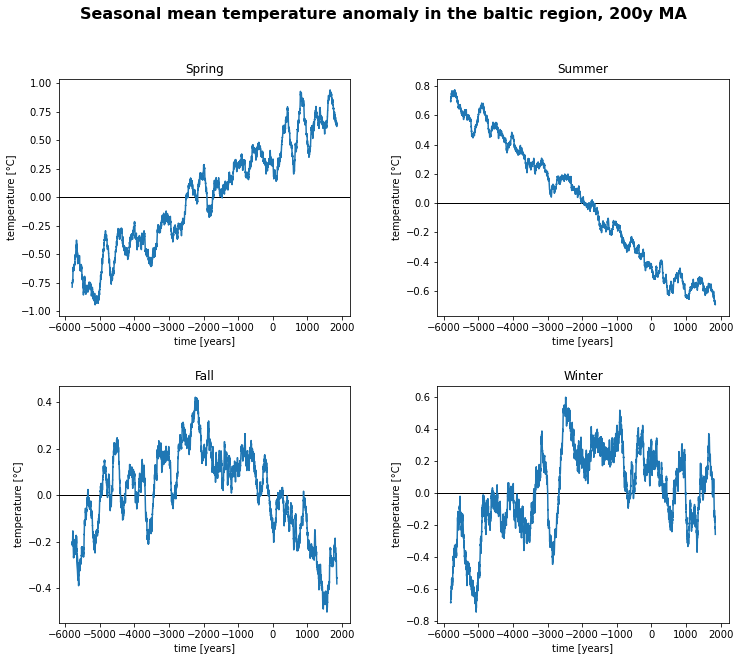

In [13]:
rolling_data = mean_temp_baltic.isel(time=slice(2, None))
rolling_data = rolling_data['var167'].rolling(time=3, center=False, min_periods=3).mean()
rolling_data = rolling_data[2::3]
seasonal_mean_temp_baltic = xr.Dataset({"var167": ("time", rolling_data)}, coords={"time": rolling_data.coords["time"]})


# Creating spring_mean_temp_baltic DataArray and applying 200y MA
spring_mean_temp_baltic = seasonal_mean_temp_baltic['var167'][0::4]
t_mean = spring_mean_temp_baltic.mean(dim=['time'])
t_mean = float(t_mean.values)
spring_mean_temp_baltic -= t_mean
spring_mean_temp_baltic.coords['time'] = range(-6000, -6000+len(spring_mean_temp_baltic))
spring_mean_temp_baltic_plot = spring_mean_temp_baltic.rolling(time=200).mean()

# Creating summer_mean_temp_baltic DataArray and applying 200y MA
summer_mean_temp_baltic = seasonal_mean_temp_baltic['var167'][1::4]
t_mean = summer_mean_temp_baltic.mean(dim=['time'])
t_mean = float(t_mean.values)
summer_mean_temp_baltic -= t_mean
summer_mean_temp_baltic.coords['time'] = range(-6000, -6000+len(summer_mean_temp_baltic))
summer_mean_temp_baltic_plot = summer_mean_temp_baltic.rolling(time=200).mean()

# Creating fall_mean_temp_baltic DataArray and applying 200y MA
fall_mean_temp_baltic = seasonal_mean_temp_baltic['var167'][2::4]
t_mean = fall_mean_temp_baltic.mean(dim=['time'])
t_mean = float(t_mean.values)
fall_mean_temp_baltic -= t_mean
fall_mean_temp_baltic.coords['time'] = range(-6000, -6000+len(fall_mean_temp_baltic))
fall_mean_temp_baltic_plot = fall_mean_temp_baltic.rolling(time=200).mean()

# Creating winter_mean_temp_baltic DataArray and applying 200y MA
winter_mean_temp_baltic = seasonal_mean_temp_baltic['var167'][3::4]
t_mean = winter_mean_temp_baltic.mean(dim=['time'])
t_mean = float(t_mean.values)
winter_mean_temp_baltic -= t_mean
winter_mean_temp_baltic.coords['time'] = range(-6000, -6000+len(winter_mean_temp_baltic))
winter_mean_temp_baltic_plot = winter_mean_temp_baltic.rolling(time=200).mean()


# Creating the four plots
fig, axs = plt.subplots(2, 2, figsize=(12,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})

im1 = axs[0,0].axhline(y=0, color='black', linewidth=1)
axs[0,0].plot(spring_mean_temp_baltic_plot['time'], spring_mean_temp_baltic_plot)
axs[0,0].set_title('Spring')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('temperature [°C]')

im2 = axs[0,1].axhline(y=0, color='black', linewidth=1)
axs[0,1].plot(summer_mean_temp_baltic_plot['time'], summer_mean_temp_baltic_plot)
axs[0,1].set_title('Summer')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('temperature [°C]')

im3 = axs[1,0].axhline(y=0, color='black', linewidth=1)
axs[1,0].plot(fall_mean_temp_baltic_plot['time'], fall_mean_temp_baltic_plot)
axs[1,0].set_title('Fall')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('temperature [°C]')

im4 = axs[1,1].axhline(y=0, color='black', linewidth=1)
axs[1,1].plot(winter_mean_temp_baltic_plot['time'], winter_mean_temp_baltic_plot)
axs[1,1].set_title('Winter')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('temperature [°C]');

fig.suptitle('Seasonal mean temperature anomaly in the baltic region, 200y MA', fontsize=16, fontweight='bold');

In [14]:
# averaging the precipitation values
prec_baltic = prec.where(mask)
prec_baltic = prec_baltic.sel(lat=slice(49, 68), lon=slice(8, 35))
mean_prec_baltic = prec_baltic.mean(dim=['lat', 'lon'])

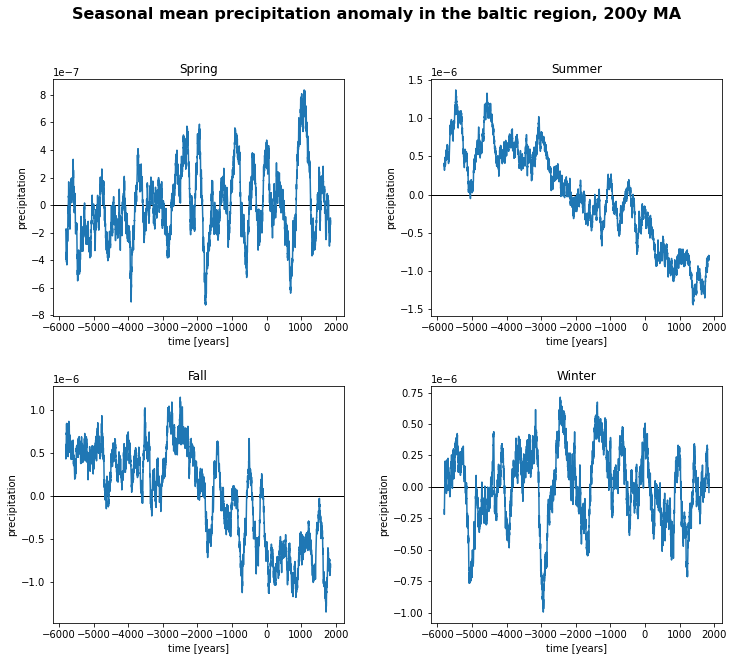

In [15]:
rolling_data = mean_prec_baltic.isel(time=slice(2, None))
rolling_data = rolling_data['var260'].rolling(time=3, center=False, min_periods=3).mean()
rolling_data = rolling_data[2::3]
seasonal_mean_prec_baltic = xr.Dataset({"var260": ("time", rolling_data)}, coords={"time": rolling_data.coords["time"]})


# Creating spring_mean_prec_baltic DataArray and applying 200y MA
spring_mean_prec_baltic = seasonal_mean_prec_baltic['var260'][0::4]
prec_mean = spring_mean_prec_baltic.mean(dim=['time'])
prec_mean = float(prec_mean.values)
spring_mean_prec_baltic -= prec_mean
spring_mean_prec_baltic.coords['time'] = range(-6000, -6000+len(spring_mean_prec_baltic))
spring_mean_prec_baltic_plot = spring_mean_prec_baltic.rolling(time=200).mean()

# Creating summer_mean_prec_baltic DataArray and applying 200y MA
summer_mean_prec_baltic = seasonal_mean_prec_baltic['var260'][1::4]
prec_mean = summer_mean_prec_baltic.mean(dim=['time'])
prec_mean = float(prec_mean.values)
summer_mean_prec_baltic -= prec_mean
summer_mean_prec_baltic.coords['time'] = range(-6000, -6000+len(summer_mean_prec_baltic))
summer_mean_prec_baltic_plot = summer_mean_prec_baltic.rolling(time=200).mean()

# Creating fall_mean_prec_baltic DataArray and applying 200y MA
fall_mean_prec_baltic = seasonal_mean_prec_baltic['var260'][2::4]
prec_mean = fall_mean_prec_baltic.mean(dim=['time'])
prec_mean = float(prec_mean.values)
fall_mean_prec_baltic -= prec_mean
fall_mean_prec_baltic.coords['time'] = range(-6000, -6000+len(fall_mean_prec_baltic))
fall_mean_prec_baltic_plot = fall_mean_prec_baltic.rolling(time=200).mean()

# Creating winter_mean_prec_baltic DataArray and applying 200y MA
winter_mean_prec_baltic = seasonal_mean_prec_baltic['var260'][3::4]
prec_mean = winter_mean_prec_baltic.mean(dim=['time'])
prec_mean = float(prec_mean.values)
winter_mean_prec_baltic -= prec_mean
winter_mean_prec_baltic.coords['time'] = range(-6000, -6000+len(winter_mean_prec_baltic))
winter_mean_prec_baltic_plot = winter_mean_prec_baltic.rolling(time=200).mean()


# Creating the four plots
fig, axs = plt.subplots(2, 2, figsize=(12,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})

im1 = axs[0,0].axhline(y=0, color='black', linewidth=1)
axs[0,0].plot(spring_mean_prec_baltic_plot['time'], spring_mean_prec_baltic_plot)
axs[0,0].set_title('Spring')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('precipitation')

im2 = axs[0,1].axhline(y=0, color='black', linewidth=1)
axs[0,1].plot(summer_mean_prec_baltic_plot['time'], summer_mean_prec_baltic_plot)
axs[0,1].set_title('Summer')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('precipitation')

im3 = axs[1,0].axhline(y=0, color='black', linewidth=1)
axs[1,0].plot(fall_mean_prec_baltic_plot['time'], fall_mean_prec_baltic_plot)
axs[1,0].set_title('Fall')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('precipitation')

im4 = axs[1,1].axhline(y=0, color='black', linewidth=1)
axs[1,1].plot(winter_mean_prec_baltic_plot['time'], winter_mean_prec_baltic_plot)
axs[1,1].set_title('Winter')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('precipitation');

fig.suptitle('Seasonal mean precipitation anomaly in the baltic region, 200y MA', fontsize=16, fontweight='bold');

In [16]:
print('The seasonal correlations between NAO pressure difference and temperature or precipitation look as follows (no MA applied):')
print('-------------------------')

from scipy.stats import pearsonr

corr, p_value = pearsonr(spring_delta_press, spring_mean_temp_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")

corr, p_value = pearsonr(summer_delta_press, summer_mean_temp_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")
    
corr, p_value = pearsonr(fall_delta_press, fall_mean_temp_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")
    
corr, p_value = pearsonr(winter_delta_press, winter_mean_temp_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")

c_spring_temp = np.corrcoef(spring_delta_press, spring_mean_temp_baltic)[0,1]
print(f"Fall NAO-Temp:     {c_spring_temp:.4f}")
c_summer_temp = np.corrcoef(summer_delta_press, summer_mean_temp_baltic)[0,1]
print(f"Winter NAO-Temp:   {c_summer_temp:.4f}")
c_fall_temp = np.corrcoef(fall_delta_press, fall_mean_temp_baltic)[0,1]
print(f"Fall NAO-Temp:     {c_fall_temp:.4f}")
c_winter_temp = np.corrcoef(winter_delta_press, winter_mean_temp_baltic)[0,1]
print(f"Winter NAO-Temp:   {c_winter_temp:.4f}")


print('-------------------------')

corr, p_value = pearsonr(spring_delta_press, spring_mean_prec_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")

corr, p_value = pearsonr(summer_delta_press, summer_mean_prec_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")
    
corr, p_value = pearsonr(fall_delta_press, fall_mean_prec_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")
    
corr, p_value = pearsonr(winter_delta_press, winter_mean_prec_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")

c_spring_prec = np.corrcoef(spring_delta_press, spring_mean_prec_baltic)[0,1]
print(f"Spring NAO-Prec:   {c_spring_prec:.4f}")
c_summer_prec = np.corrcoef(summer_delta_press, summer_mean_prec_baltic)[0,1]
print(f"Summer NAO-Prec:  {c_summer_prec:.4f}")
c_fall_prec = np.corrcoef(fall_delta_press, fall_mean_prec_baltic)[0,1]
print(f"Fall NAO-Prec:    {c_fall_prec:.4f}")
c_winter_prec = np.corrcoef(winter_delta_press, winter_mean_prec_baltic)[0,1]
print(f"Winter NAO-Prec:   {c_winter_prec:.4f}")


print('-------------------------')

corr, p_value = pearsonr(spring_mean_temp_baltic, spring_mean_prec_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")

corr, p_value = pearsonr(summer_mean_temp_baltic, summer_mean_prec_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")
    
corr, p_value = pearsonr(fall_mean_temp_baltic, fall_mean_prec_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")
    
corr, p_value = pearsonr(winter_mean_temp_baltic, winter_mean_prec_baltic)
if p_value < 0.05:
    print(f"The correlation coefficient of {corr:.2f} is significant with p-value of {p_value:.2e}")
else:
    print(f"The correlation coefficient of {corr:.2f} is not significant with p-value of {p_value:.2e}")


c_spring_temp_prec = np.corrcoef(spring_mean_temp_baltic, spring_mean_prec_baltic)[0,1]
print(f"Spring Temp-Prec:  {c_spring_temp_prec:.4f}")
c_summer_temp_prec = np.corrcoef(summer_mean_temp_baltic, summer_mean_prec_baltic)[0,1]
print(f"Summer Temp-Prec: {c_summer_temp_prec:.4f}")
c_fall_temp_prec = np.corrcoef(fall_mean_temp_baltic, fall_mean_prec_baltic)[0,1]
print(f"Fall Temp-Prec:    {c_fall_temp_prec:.4f}")
c_winter_temp_prec = np.corrcoef(winter_mean_temp_baltic, winter_mean_prec_baltic)[0,1]
print(f"Winter Temp-Prec:  {c_winter_temp_prec:.4f}")

The seasonal correlations between NAO pressure difference and temperature or precipitation look as follows (no MA applied):
-------------------------
The correlation coefficient of 0.32 is significant with p-value of 1.24e-181
The correlation coefficient of 0.33 is significant with p-value of 1.68e-193
The correlation coefficient of 0.41 is significant with p-value of 1.96e-315
The correlation coefficient of 0.52 is significant with p-value of 0.00e+00
Fall NAO-Temp:     0.3161
Winter NAO-Temp:   0.3258
Fall NAO-Temp:     0.4096
Winter NAO-Temp:   0.5213
-------------------------
The correlation coefficient of -0.06 is significant with p-value of 5.11e-07
The correlation coefficient of -0.15 is significant with p-value of 1.76e-40
The correlation coefficient of -0.13 is significant with p-value of 3.60e-32
The correlation coefficient of 0.28 is significant with p-value of 2.71e-144
Spring NAO-Prec:   -0.0566
Summer NAO-Prec:  -0.1495
Fall NAO-Prec:    -0.1327
Winter NAO-Prec:   0.2828


3MAP:

In [17]:
mask_sea = xr.zeros_like(mask, dtype=bool)
mask_sea[77,100] = True;
mask_sea[77,101] = True;
mask_sea[77,102] = True;
mask_sea[77,103] = True;
mask_sea[77,104] = True;
mask_sea[77,105] = True;
mask_sea[77,106] = True;
mask_sea[78,101] = True;
mask_sea[78,104] = True;
mask_sea[78,105] = True;
mask_sea[78,106] = True;
mask_sea[79,104] = True;
mask_sea[79,105] = True;
mask_sea[79,106] = True;
mask_sea[79,107] = True;
mask_sea[79,108] = True;
mask_sea[80,104] = True;
mask_sea[80,105] = True;
mask_sea[80,106] = True;
mask_sea[80,107] = True;
mask_sea[80,109] = True;
mask_sea[80,110] = True;
mask_sea[81,105] = True;
mask_sea[81,106] = True;
mask_sea[81,107] = True;
mask_sea[82,106] = True;
mask_sea[82,107] = True;
mask_sea[82,108] = True;


mask_land_s = xr.zeros_like(mask, dtype=bool)
mask_land_s[74,105] = True;
mask_land_s[74,106] = True;
mask_land_s[74,107] = True;
mask_land_s[75,104] = True;
mask_land_s[75,105] = True;
mask_land_s[75,106] = True;
mask_land_s[75,107] = True;
mask_land_s[75,108] = True;
mask_land_s[76,101] = True;
mask_land_s[76,102] = True;
mask_land_s[76,103] = True;
mask_land_s[76,104] = True;
mask_land_s[76,105] = True;
mask_land_s[76,106] = True;
mask_land_s[76,107] = True;
mask_land_s[76,108] = True;
mask_land_s[76,109] = True;
mask_land_s[77,107] = True;
mask_land_s[77,108] = True;
mask_land_s[77,109] = True;
mask_land_s[78,102] = True;
mask_land_s[78,103] = True;
mask_land_s[78,107] = True;
mask_land_s[78,108] = True;
mask_land_s[78,109] = True;
mask_land_s[78,110] = True;
mask_land_s[78,111] = True;
mask_land_s[78,112] = True;
mask_land_s[79,102] = True;
mask_land_s[79,103] = True;
mask_land_s[79,109] = True;
mask_land_s[79,110] = True;
mask_land_s[79,111] = True;
mask_land_s[79,112] = True;


mask_land_n = xr.zeros_like(mask, dtype=bool)
mask_land_n[80,102] = True;
mask_land_n[80,103] = True;
mask_land_n[80,104] = True;
mask_land_n[80,108] = True;
mask_land_n[80,111] = True;
mask_land_n[80,112] = True;
mask_land_n[80,113] = True;
mask_land_n[81,103] = True;
mask_land_n[81,104] = True;
mask_land_n[81,107] = True;
mask_land_n[81,108] = True;
mask_land_n[81,109] = True;
mask_land_n[81,110] = True;
mask_land_n[82,104] = True;
mask_land_n[82,105] = True;
mask_land_n[82,109] = True;
mask_land_n[82,110] = True;
mask_land_n[83,105] = True;
mask_land_n[83,106] = True;
mask_land_n[83,107] = True;
mask_land_n[83,108] = True;
mask_land_n[83,109] = True;
mask_land_n[83,110] = True;

Since the NAO is a known driver of Baltic Sea climate, let's check what influence it had on the specific climate periods HCO, MCA, LIA1 and LIA2:

In [ ]:
def linear_regression_lag(x, y, shiftx=0, shifty=0, dim = "time"):
    """    
    Linear regression along the given `dim`.  
    
    Note that x is the independent variable and y is the dependent variable.
    """ 
    if shiftx != 0:
        x   = x.shift(time = shiftx).dropna(dim='time')
        x, y = xr.align(x, y)
    if shifty != 0:
        y   = y.shift(time = shifty).dropna(dim='time')
        x, y = xr.align(x, y)
 
    n = y.notnull().sum(dim)
    nanmask = np.isnan(y).all(dim)
    
    xmean = x.mean(dim)
    ymean = y.mean(dim)
    xstd  = x.std(dim)
    ystd  = y.std(dim)
    
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    cor   = cov / (xstd*ystd)
    
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    df = n - 2
    TINY = 1.0e-20
    tstats = cor * np.sqrt(df / ((1.0 - cor + TINY) * (1.0 + cor + TINY)))
    stderr = slope/tstats
    
    pval   = stats.t.sf(tstats, n-2)*2 #for t-tailed test
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)
    return xr.Dataset(
        {
            "slope": slope,
            "intercept": intercept,
            "r_value": cor.fillna(0).where(~nanmask),
            "p_value": pval,
            "std_err": stderr.where(~np.isinf(stderr), 0),
        }
    )

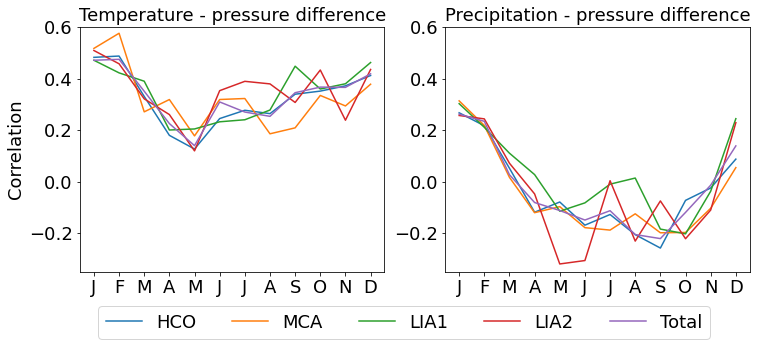

In [20]:
# correlation monthly for climate periods

temp_hco = np.zeros((12,1097))
prec_hco = np.zeros((12,1097))
press_hco = np.zeros((12,1097))
temp_mca = np.zeros((12,239))
prec_mca = np.zeros((12,239))
press_mca = np.zeros((12,239))
temp_lia1 = np.zeros((12,150))
prec_lia1 = np.zeros((12,150))
press_lia1 = np.zeros((12,150))
temp_lia2 = np.zeros((12,166))
prec_lia2 = np.zeros((12,166))
press_lia2 = np.zeros((12,166))
corr_temp_prec_hco = np.zeros(12)
corr_temp_prec_mca = np.zeros(12)
corr_temp_prec_lia1 = np.zeros(12)
corr_temp_prec_lia2 = np.zeros(12)
corr_temp_press_hco = np.zeros(12)
corr_temp_press_mca = np.zeros(12)
corr_temp_press_lia1 = np.zeros(12)
corr_temp_press_lia2 = np.zeros(12)
corr_prec_press_hco = np.zeros(12)
corr_prec_press_mca = np.zeros(12)
corr_prec_press_lia1 = np.zeros(12)
corr_prec_press_lia2 = np.zeros(12)
temp_1 = np.zeros((12,7850))
prec_1 = np.zeros((12,7850))
press_1 = np.zeros((12,7850))
corr_temp_prec_1 = np.zeros(12)
corr_temp_press_1 = np.zeros(12)
corr_prec_press_1 = np.zeros(12)

for i in range (0,12):
    temp_hco[i] = mean_temp_baltic['var167'][3336*12+i:4433*12:12]
    prec_hco[i] = mean_prec_baltic['var260'][3336*12+i:4433*12:12]
    press_hco[i] = delta_press_monthly[3336*12+i:4433*12:12]
    temp_mca[i] = mean_temp_baltic['var167'][6604*12+i:6843*12:12]
    prec_mca[i] = mean_prec_baltic['var260'][6604*12+i:6843*12:12]
    press_mca[i] = delta_press_monthly[6604*12+i:6843*12:12]
    temp_lia1[i] = mean_temp_baltic['var167'][7130*12+i:7280*12:12]
    prec_lia1[i] = mean_prec_baltic['var260'][7130*12+i:7280*12:12]
    press_lia1[i] = delta_press_monthly[7130*12+i:7280*12:12]
    temp_lia2[i] = mean_temp_baltic['var167'][7364*12+i:7530*12:12]
    prec_lia2[i] = mean_prec_baltic['var260'][7364*12+i:7530*12:12]
    press_lia2[i] = delta_press_monthly[7364*12+i:7530*12:12]
    
    corr_temp_prec_hco[i] = np.corrcoef(temp_hco[i], prec_hco[i])[0,1]
    corr_temp_prec_mca[i] = np.corrcoef(temp_mca[i], prec_mca[i])[0,1]
    corr_temp_prec_lia1[i] = np.corrcoef(temp_lia1[i], prec_lia1[i])[0,1]
    corr_temp_prec_lia2[i] = np.corrcoef(temp_lia2[i], prec_lia2[i])[0,1]
    corr_temp_press_hco[i] = np.corrcoef(temp_hco[i], press_hco[i])[0,1]
    corr_temp_press_mca[i] = np.corrcoef(temp_mca[i], press_mca[i])[0,1]
    corr_temp_press_lia1[i] = np.corrcoef(temp_lia1[i], press_lia1[i])[0,1]
    corr_temp_press_lia2[i] = np.corrcoef(temp_lia2[i], press_lia2[i])[0,1]
    corr_prec_press_hco[i] = np.corrcoef(prec_hco[i], press_hco[i])[0,1]
    corr_prec_press_mca[i] = np.corrcoef(prec_mca[i], press_mca[i])[0,1]
    corr_prec_press_lia1[i] = np.corrcoef(prec_lia1[i], press_lia1[i])[0,1]
    corr_prec_press_lia2[i] = np.corrcoef(prec_lia2[i], press_lia2[i])[0,1]
    temp_1[i] = mean_temp_baltic['var167'][i:94200:12]
    prec_1[i] = mean_prec_baltic['var260'][i:94200:12]
    press_1[i] = delta_press_monthly[i:94200:12]
    corr_temp_prec_1[i] = np.corrcoef(temp_1[i], prec_1[i])[0,1]
    corr_temp_press_1[i] = np.corrcoef(temp_1[i], press_1[i])[0,1]
    corr_prec_press_1[i] = np.corrcoef(prec_1[i], press_1[i])[0,1]
    
    
months = list(calendar.month_name)[1:]  # get month names as a list
abbrev_months = [month[:3] for month in months]  # get abbreviated month names

fig, axs = plt.subplots(1, 2, figsize=(12,4.5))
#fig.suptitle('Monthly correlation for different climate periods', fontweight='bold', fontsize=17)

axs[0].plot(abbrev_months, corr_temp_press_hco, label='HCO')
axs[0].plot(abbrev_months, corr_temp_press_mca, label='MCA')
axs[0].plot(abbrev_months, corr_temp_press_lia1, label='LIA1')
axs[0].plot(abbrev_months, corr_temp_press_lia2, label='LIA2')
axs[0].plot(abbrev_months, corr_temp_press_1, label='Total')
axs[0].set_ylim([-0.35, 0.6])
axs[0].set_xticks(range(len(abbrev_months)))
axs[0].set_xticklabels([month[0] for month in abbrev_months])
axs[0].tick_params(axis='both', which='major', labelsize=18)
axs[0].set_ylabel('Correlation', fontsize=18)
axs[0].set_title('Temperature - pressure difference', fontsize=18)
axs[1].plot(abbrev_months, corr_prec_press_hco)
axs[1].plot(abbrev_months, corr_prec_press_mca)
axs[1].plot(abbrev_months, corr_prec_press_lia1)
axs[1].plot(abbrev_months, corr_prec_press_lia2)
axs[1].plot(abbrev_months, corr_prec_press_1)
axs[1].set_ylim([-0.35, 0.6])
axs[1].set_xticks(range(len(abbrev_months)))
axs[1].set_xticklabels([month[0] for month in abbrev_months])
axs[1].tick_params(axis='both', which='major', labelsize=18)
#axs[1].set_ylabel('Correlation', fontsize=18)
axs[1].set_title('Precipitation - pressure difference', fontsize=18)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.11), ncol=9, fontsize=18)

plt.savefig("/students_files/marti/plots/res_16_nao_correlation_periods", bbox_inches='tight');

# BA Plot:

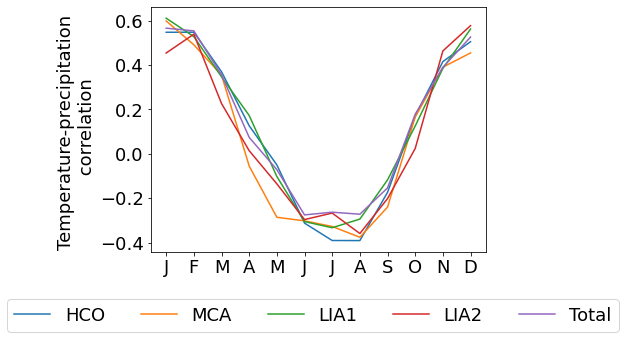

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))

ax.plot(abbrev_months, corr_temp_prec_hco, label='HCO')
ax.plot(abbrev_months, corr_temp_prec_mca, label='MCA')
ax.plot(abbrev_months, corr_temp_prec_lia1, label='LIA1')
ax.plot(abbrev_months, corr_temp_prec_lia2, label='LIA2')
ax.plot(abbrev_months, corr_temp_prec_1, label='Total')
ax.set_ylabel('Temperature-precipitation \n correlation', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xticks(range(len(abbrev_months)))
ax.set_xticklabels([month[0] for month in abbrev_months])
#ax.set_title('Temperature - precipitation')

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=18);

plt.savefig("/students_files/marti/plots/res_14_tempprec_correlation_periods", bbox_inches='tight');

In the following we will look at the seasonal correlation between temperature, pressure and precipitation for different moving average lengths:

In [19]:
#WINTER
corr_temp_press_winter =  np.zeros(2000)
corr_prec_press_winter =  np.zeros(2000)
corr_temp_prec_winter =  np.zeros(2000)
for i in range (0,2000):
    winter_temp = winter_mean_temp_baltic.rolling(time=i+1).mean().dropna('time')
    winter_prec = winter_mean_prec_baltic.rolling(time=i+1).mean().dropna('time')
    winter_press = winter_delta_press.rolling(time=i+1).mean().dropna('time')
    corr_temp_press_winter[i] = np.corrcoef(winter_press, winter_temp)[0,1]
    corr_prec_press_winter[i] = np.corrcoef(winter_press, winter_prec)[0,1]
    corr_temp_prec_winter[i] = np.corrcoef(winter_prec, winter_temp)[0,1]

In [20]:
#SPRING,SUMMER,FALL
corr_temp_press_spring =  np.zeros(2000)
corr_prec_press_spring =  np.zeros(2000)
corr_temp_prec_spring =  np.zeros(2000)
for i in range (0,2000):
    spring_temp = spring_mean_temp_baltic.rolling(time=i+1).mean().dropna('time')
    spring_prec = spring_mean_prec_baltic.rolling(time=i+1).mean().dropna('time')
    spring_press = spring_delta_press.rolling(time=i+1).mean().dropna('time')
    corr_temp_press_spring[i] = np.corrcoef(spring_press, spring_temp)[0,1]
    corr_prec_press_spring[i] = np.corrcoef(spring_press, spring_prec)[0,1]
    corr_temp_prec_spring[i] = np.corrcoef(spring_prec, spring_temp)[0,1]

In [21]:
corr_temp_press_summer =  np.zeros(2000)
corr_prec_press_summer =  np.zeros(2000)
corr_temp_prec_summer =  np.zeros(2000)
for i in range (0,2000):
    summer_temp = summer_mean_temp_baltic.rolling(time=i+1).mean().dropna('time')
    summer_prec = summer_mean_prec_baltic.rolling(time=i+1).mean().dropna('time')
    summer_press = summer_delta_press.rolling(time=i+1).mean().dropna('time')
    corr_temp_press_summer[i] = np.corrcoef(summer_press, summer_temp)[0,1]
    corr_prec_press_summer[i] = np.corrcoef(summer_press, summer_prec)[0,1]
    corr_temp_prec_summer[i] = np.corrcoef(summer_prec, summer_temp)[0,1]

In [22]:
corr_temp_press_fall =  np.zeros(2000)
corr_prec_press_fall =  np.zeros(2000)
corr_temp_prec_fall =  np.zeros(2000)
for i in range (0,2000):
    fall_temp = fall_mean_temp_baltic.rolling(time=i+1).mean().dropna('time')
    fall_prec = fall_mean_prec_baltic.rolling(time=i+1).mean().dropna('time')
    fall_press = fall_delta_press.rolling(time=i+1).mean().dropna('time')
    corr_temp_press_fall[i] = np.corrcoef(fall_press, fall_temp)[0,1]
    corr_prec_press_fall[i] = np.corrcoef(fall_press, fall_prec)[0,1]
    corr_temp_prec_fall[i] = np.corrcoef(fall_prec, fall_temp)[0,1]

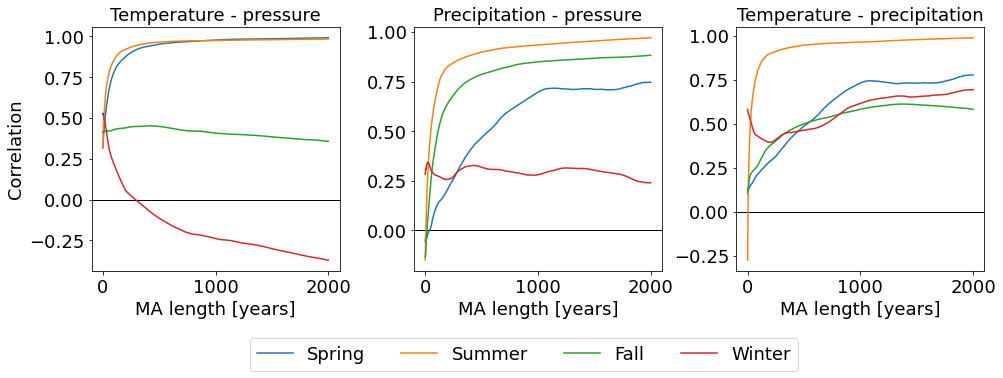

In [26]:
time = np.arange(0,2000)

fig, axs = plt.subplots(1, 3, figsize=(16,4.5), gridspec_kw={"hspace": 0.3, "wspace": 0.3})
#fig.suptitle('Seasonal correlation for moving averages from 1 to 2000 years', fontsize=16, fontweight='bold');

im1 = axs[0].axhline(y=0, color='black', linewidth=1)
axs[0].plot(time, corr_temp_press_spring, label='Spring')
axs[0].plot(time, corr_temp_press_summer, label='Summer')
axs[0].plot(time, corr_temp_press_fall, label='Fall')
axs[0].plot(time, corr_temp_press_winter, label='Winter')
axs[0].set_title('Temperature - pressure', fontsize=18)
axs[0].set_xlabel('MA length [years]', fontsize=18)
axs[0].set_ylabel('Correlation', fontsize=18)
axs[0].tick_params(axis='both', labelsize=18)

im2 = axs[1].axhline(y=0, color='black', linewidth=1)
axs[1].plot(time, corr_prec_press_spring)
axs[1].plot(time, corr_prec_press_summer)
axs[1].plot(time, corr_prec_press_fall)
axs[1].plot(time, corr_prec_press_winter)
axs[1].set_title('Precipitation - pressure', fontsize=18)
axs[1].set_xlabel('MA length [years]', fontsize=18)
#axs[1].set_ylabel('Correlation')
axs[1].tick_params(axis='both', labelsize=18)

im3 = axs[2].axhline(y=0, color='black', linewidth=1)
axs[2].plot(time, corr_temp_prec_spring)
axs[2].plot(time, corr_temp_prec_summer)
axs[2].plot(time, corr_temp_prec_fall)
axs[2].plot(time, corr_temp_prec_winter)
axs[2].set_title('Temperature - precipitation', fontsize=18)
axs[2].set_xlabel('MA length [years]', fontsize=18)
#axs[2].set_ylabel('Correlation')
axs[2].tick_params(axis='both', labelsize=18);

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.21), ncol=4, fontsize=18)

plt.savefig("/students_files/marti/plots/res_20_ma_length", bbox_inches='tight');

In [115]:
# Summary

# thesis: to more the correlation coefficient converges to one, the less correlation 
# no relation between nao and temp/prec in summer, strong correlation in winter and some in fall/spring
# generally 4 types of curves
#     1. converging straight to r=1
#     2. winter temp-press going from positive to negative
#     3. winter prec-press, winter temp-prec, fall temp-press staying more or less constant
#     4. spring prec-press and spring temp-prec

This looks very interesting. I would assume that a convergence to r=1 indicates no correlation and we can see that this is not the case not only for winter but also for some spring/fall data. Consequently it would be interesting to look at the monthly correlation and how it develops over the year:

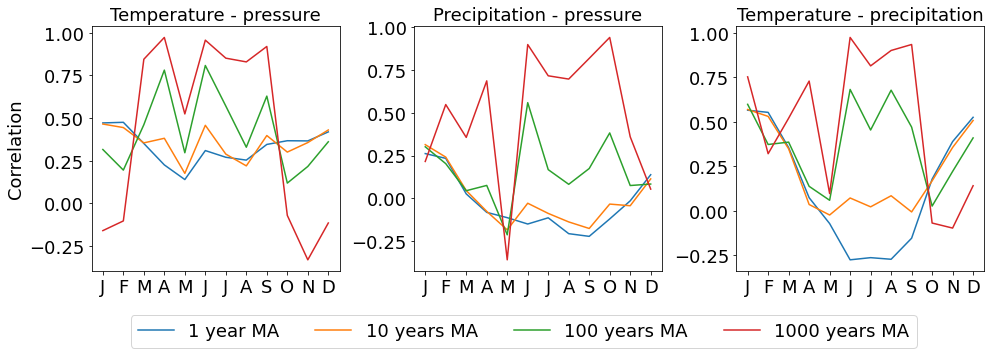

In [25]:
# 1, 10, 100, 1000y MAs for monthly data

temp_1 = np.zeros((12,7850))
prec_1 = np.zeros((12,7850))
press_1 = np.zeros((12,7850))
temp_10 = np.zeros((12,7841))
prec_10 = np.zeros((12,7841))
press_10 = np.zeros((12,7841))
temp_100 = np.zeros((12,7751))
prec_100 = np.zeros((12,7751))
press_100 = np.zeros((12,7751))
temp_1000 = np.zeros((12,6851))
prec_1000 = np.zeros((12,6851))
press_1000 = np.zeros((12,6851))
corr_temp_prec_1 = np.zeros(12)
corr_temp_prec_10 = np.zeros(12)
corr_temp_prec_100 = np.zeros(12)
corr_temp_prec_1000 = np.zeros(12)
corr_temp_press_1 = np.zeros(12)
corr_temp_press_10 = np.zeros(12)
corr_temp_press_100 = np.zeros(12)
corr_temp_press_1000 = np.zeros(12)
corr_prec_press_1 = np.zeros(12)
corr_prec_press_10 = np.zeros(12)
corr_prec_press_100 = np.zeros(12)
corr_prec_press_1000 = np.zeros(12)


for i in range (0,12):
    temp_1[i] = mean_temp_baltic['var167'][i:94200:12]
    prec_1[i] = mean_prec_baltic['var260'][i:94200:12]
    press_1[i] = delta_press_monthly[i:94200:12]
    temp_10[i] = np.convolve(temp_1[i], np.ones(10)/10, mode='valid')
    prec_10[i] = np.convolve(prec_1[i], np.ones(10)/10, mode='valid')
    press_10[i] = np.convolve(press_1[i], np.ones(10)/10, mode='valid')
    temp_100[i] = np.convolve(temp_1[i], np.ones(100)/100, mode='valid')
    prec_100[i] = np.convolve(prec_1[i], np.ones(100)/100, mode='valid')
    press_100[i] = np.convolve(press_1[i], np.ones(100)/100, mode='valid')
    temp_1000[i] = np.convolve(temp_1[i], np.ones(1000)/1000, mode='valid')
    prec_1000[i] = np.convolve(prec_1[i], np.ones(1000)/1000, mode='valid')
    press_1000[i] = np.convolve(press_1[i], np.ones(1000)/1000, mode='valid')
    
    corr_temp_prec_1[i] = np.corrcoef(temp_1[i], prec_1[i])[0,1]
    corr_temp_prec_10[i] = np.corrcoef(temp_10[i], prec_10[i])[0,1]
    corr_temp_prec_100[i] = np.corrcoef(temp_100[i], prec_100[i])[0,1]
    corr_temp_prec_1000[i] = np.corrcoef(temp_1000[i], prec_1000[i])[0,1]
    corr_temp_press_1[i] = np.corrcoef(temp_1[i], press_1[i])[0,1]
    corr_temp_press_10[i] = np.corrcoef(temp_10[i], press_10[i])[0,1]
    corr_temp_press_100[i] = np.corrcoef(temp_100[i], press_100[i])[0,1]
    corr_temp_press_1000[i] = np.corrcoef(temp_1000[i], press_1000[i])[0,1]
    corr_prec_press_1[i] = np.corrcoef(prec_1[i], press_1[i])[0,1]
    corr_prec_press_10[i] = np.corrcoef(prec_10[i], press_10[i])[0,1]
    corr_prec_press_100[i] = np.corrcoef(prec_100[i], press_100[i])[0,1]
    corr_prec_press_1000[i] = np.corrcoef(prec_1000[i], press_1000[i])[0,1]


months = list(calendar.month_name)[1:]  # get month names as a list
abbrev_months = [month[:3] for month in months]  # get abbreviated month names

fig, axs = plt.subplots(1, 3, figsize=(16,4.5), gridspec_kw={"hspace": 0.3, "wspace": 0.3})
#fig.suptitle('Monthly correlation for different moving averages', fontweight='bold', fontsize=17)

axs[0].plot(abbrev_months, corr_temp_press_1, label='1 year MA')
axs[0].plot(abbrev_months, corr_temp_press_10, label='10 years MA')
axs[0].plot(abbrev_months, corr_temp_press_100, label='100 years MA')
axs[0].plot(abbrev_months, corr_temp_press_1000, label='1000 years MA')
axs[0].set_ylabel('Correlation', fontsize=18)
axs[0].set_title('Temperature - pressure', fontsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=18)
axs[0].set_xticks(range(len(abbrev_months)))
axs[0].set_xticklabels([month[0] for month in abbrev_months])
axs[1].plot(abbrev_months, corr_prec_press_1)
axs[1].plot(abbrev_months, corr_prec_press_10)
axs[1].plot(abbrev_months, corr_prec_press_100)
axs[1].plot(abbrev_months, corr_prec_press_1000)
#axs[1].set_ylabel('Correlation')
axs[1].set_title('Precipitation - pressure', fontsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=18)
axs[1].set_xticks(range(len(abbrev_months)))
axs[1].set_xticklabels([month[0] for month in abbrev_months])
axs[2].plot(abbrev_months, corr_temp_prec_1)
axs[2].plot(abbrev_months, corr_temp_prec_10)
axs[2].plot(abbrev_months, corr_temp_prec_100)
axs[2].plot(abbrev_months, corr_temp_prec_1000)
#axs[2].set_ylabel('Correlation')
axs[2].set_title('Temperature - precipitation', fontsize=18)
axs[2].tick_params(axis='both', which='major', labelsize=18)
axs[2].set_xticks(range(len(abbrev_months)))
axs[2].set_xticklabels([month[0] for month in abbrev_months])

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.14), fontsize=18, ncol=9)
plt.savefig("/students_files/marti/plots/res_21_ma_seascycle", bbox_inches='tight');